<a href="https://colab.research.google.com/github/Randommss/California-Wildfire-Severity/blob/main/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#1. Import Libraraies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier


In [ ]:
#2. Read csv file
df = pd.read_csv("/content/sample_data/California Wildfire Damage.csv")
df.head()

,Incident_ID,Date,Location,Area_Burned (Acres),Homes_Destroyed,Businesses_Destroyed,Vehicles_Damaged,Injuries,Fatalities,Estimated_Financial_Loss (Million $),Cause
0,INC1000,2020-11-22,Sonoma County,14048,763,474,235,70,19,2270.57,Lightning
1,INC1001,2021-09-23,Sonoma County,33667,1633,4,263,100,2,1381.14,Lightning
2,INC1002,2022-02-10,Shasta County,26394,915,291,31,50,6,2421.96,Human Activity
3,INC1003,2021-05-17,Sonoma County,20004,1220,128,34,28,0,3964.16,Unknown
4,INC1004,2021-09-22,Sonoma County,40320,794,469,147,0,15,1800.09,Unknown


In [ ]:
#3. Clean column names
df.columns = (
    df.columns.str.strip()
              .str.replace(" ", "_")
              .str.replace("(", "")
              .str.replace(")", "")
              .str.replace("$", "")
)
df.head()

,Incident_ID,Date,Location,Area_Burned_Acres,Homes_Destroyed,Businesses_Destroyed,Vehicles_Damaged,Injuries,Fatalities,Estimated_Financial_Loss_Million_,Cause
0,INC1000,2020-11-22,Sonoma County,14048,763,474,235,70,19,2270.57,Lightning
1,INC1001,2021-09-23,Sonoma County,33667,1633,4,263,100,2,1381.14,Lightning
2,INC1002,2022-02-10,Shasta County,26394,915,291,31,50,6,2421.96,Human Activity
3,INC1003,2021-05-17,Sonoma County,20004,1220,128,34,28,0,3964.16,Unknown
4,INC1004,2021-09-22,Sonoma County,40320,794,469,147,0,15,1800.09,Unknown


In [ ]:
#4. Feature Engineering
# Convert Date
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

# Temporal features
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df["DayOfYear"] = df["Date"].dt.dayofyear
df["Season"] = df["Month"] % 12 // 3   # 0=Winter,1=Spring,2=Summer,3=Fall

# Combined features
df["Total_Structures_Destroyed"] = df["Homes_Destroyed"] + df["Businesses_Destroyed"]
df["Total_Damage_Indicators"] = (
    df["Homes_Destroyed"] + df["Businesses_Destroyed"] + df["Vehicles_Damaged"]
)

# Log transforms for regression
df["Log_Area"] = np.log1p(df["Area_Burned_Acres"])
df["Log_Loss"] = np.log1p(df["Estimated_Financial_Loss_Million_"])

In [ ]:
#5. Create Severity Classes
def severity_class(acres):
    if acres < 10000:
        return "Low"
    elif acres < 25000:
        return "Medium"
    elif acres < 40000:
        return "High"
    else:
        return "Extreme"

df["Severity_Class"] = df["Area_Burned_Acres"].apply(severity_class)

In [ ]:
#6. Select Features
categorical = ["Location", "Cause"]
numerical = [
    "Year", "Month", "DayOfYear", "Season",
    "Homes_Destroyed", "Businesses_Destroyed", "Vehicles_Damaged",
    "Injuries", "Fatalities",
    "Total_Structures_Destroyed", "Total_Damage_Indicators"
]

X = df[categorical + numerical]


In [ ]:
#7. Random Forest Regression- Regression Area Burned
# Train/Test Split
y_area = df["Log_Area"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y_area, test_size=0.2, random_state=42
)


In [ ]:
# Pipeline + Model
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical),
        ("num", "passthrough", numerical)
    ]
)

rf_area = RandomForestRegressor(
    n_estimators=300,
    max_depth=12,
    min_samples_split=4,
    random_state=42
)

model_area = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", rf_area)
])

model_area.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Location', 'Cause']),
                                                 ('num', 'passthrough',
                                                  ['Year', 'Month', 'DayOfYear',
                                                   'Season', 'Homes_Destroyed',
                                                   'Businesses_Destroyed',
                                                   'Vehicles_Damaged',
                                                   'Injuries', 'Fatalities',
                                                   'Total_Structures_Destroyed',
                                                   'Total_Damage_Indicators'])])),
                ('model',
                 RandomForestRegressor(max_depth=12, min_samples_split=4,
                                       n_estimators=300, random_state=42))])

In [ ]:
# Evaluate Regression/ Root Mean Square
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

true_area = np.expm1(y_test)
pred_area = np.expm1(pred_log)

mse = mean_squared_error(true_area, pred_log)
rmse = np.sqrt(mse)
r2 = r2_score(true_area, pred_log)

print("Area Burned Prediction:")
print("RMSE:", rmse)
print("R²:", r2)


Area Burned Prediction:
RMSE: 28140.754820335176
R²: -4.023705408619031


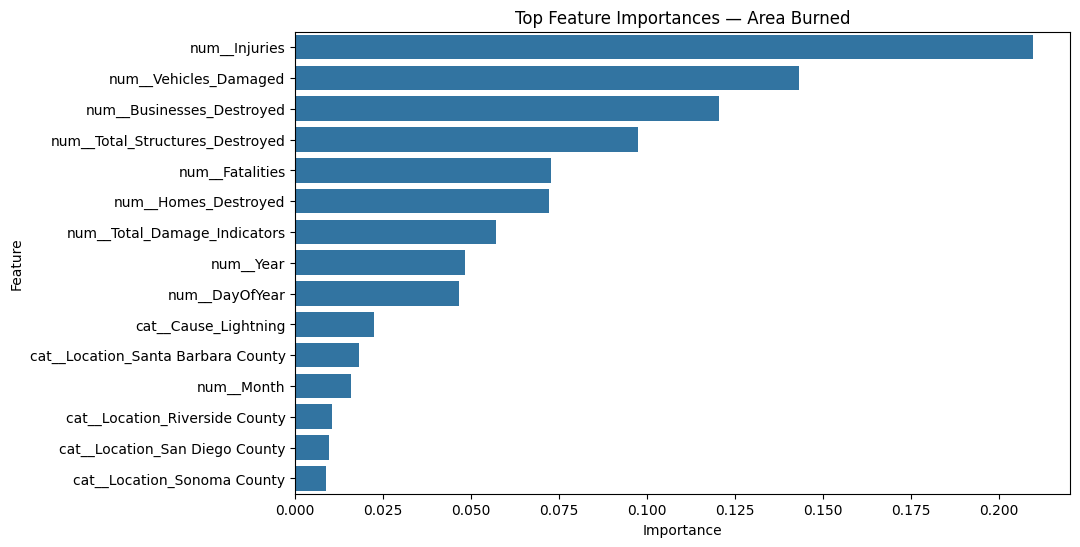

In [ ]:
# Feature Importance Plot
importances = model_area.named_steps["model"].feature_importances_
feature_names = model_area.named_steps["preprocess"].get_feature_names_out()

fi = pd.DataFrame({"Feature": feature_names, "Importance": importances})
fi = fi.sort_values("Importance", ascending=False).head(15)

plt.figure(figsize=(10,6))
sns.barplot(data=fi, x="Importance", y="Feature")
plt.title("Top Feature Importances — Area Burned")
plt.show()

In [ ]:
# Severity class
def severity_class(acres):
    if acres < 10000:
        return "Low"
    elif acres < 25000:
        return "Medium"
    elif acres < 40000:
        return "High"
    else:
        return "Extreme"

df["Severity_Class"] = df["Area_Burned_Acres"].apply(severity_class)

df[["Incident_ID", "Area_Burned_Acres", "Severity_Class"]].head()


,Incident_ID,Area_Burned_Acres,Severity_Class
0,INC1000,14048,Medium
1,INC1001,33667,High
2,INC1002,26394,High
3,INC1003,20004,Medium
4,INC1004,40320,Extreme


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Predictions already made
pred_log = model_loss.predict(X_test)

# Inverse log transform
pred_loss = np.expm1(pred_log)
true_loss = np.expm1(y_test)

# Metrics
mse = mean_squared_error(true_loss, pred_loss)
rmse = np.sqrt(mse)
r2 = r2_score(true_loss, pred_loss)

print("Financial Loss Prediction:")
print("RMSE:", rmse)
print("R²:", r2)


Financial Loss Prediction:
RMSE: 26518.393607799142
R²: -3.461152861357899


In [ ]:
# Train/Test Split
y_class = df["Severity_Class"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y_class, test_size=0.2, random_state=42
)


In [ ]:
# RF Model
rf_class = RandomForestClassifier(
    n_estimators=300,
    max_depth=15,
    class_weight="balanced",
    random_state=42
)

model_class = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", rf_class)
])

model_class.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Location', 'Cause']),
                                                 ('num', 'passthrough',
                                                  ['Year', 'Month', 'DayOfYear',
                                                   'Season', 'Homes_Destroyed',
                                                   'Businesses_Destroyed',
                                                   'Vehicles_Damaged',
                                                   'Injuries', 'Fatalities',
                                                   'Total_Structures_Destroyed',
                                                   'Total_Damage_Indicators'])])),
                ('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=15,
                                        n_estimators=300, random_state=42))])

              precision    recall  f1-score   support

     Extreme       0.00      0.00      0.00         3
        High       0.12      0.17      0.14         6
         Low       0.00      0.00      0.00         3
      Medium       0.38      0.38      0.38         8

    accuracy                           0.20        20
   macro avg       0.12      0.14      0.13        20
weighted avg       0.19      0.20      0.19        20



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


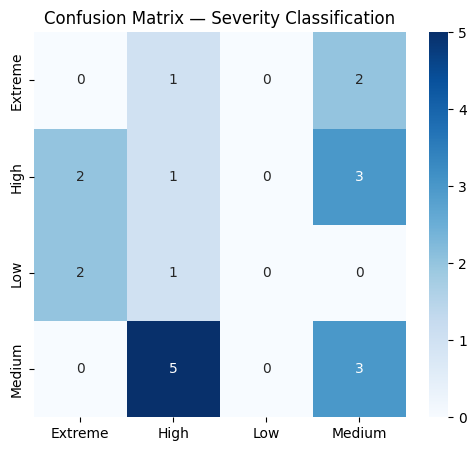

In [ ]:
# Classification
pred_class = model_class.predict(X_test)

print(classification_report(y_test, pred_class))

cm = confusion_matrix(y_test, pred_class)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=model_class.classes_,
            yticklabels=model_class.classes_)
plt.title("Confusion Matrix — Severity Classification")
plt.show()